In [2]:
import os

In [3]:
os.getcwd()

'/content'

In [4]:
!pip install datatable

     |████████████████████████████████| 96.9 MB 63 kB/s 


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datatable as dt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten, InputLayer, Dropout, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

from warnings import filterwarnings
filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [7]:
my_seed = 42

np.random.seed(my_seed)
tf.random.set_seed(my_seed)

In [10]:
#df_train = pd.read_csv("./tabular/train.csv")
#df_test = pd.read_csv("./tabular/test.csv")

### load dataframes
df_train = dt.fread('./drive/MyDrive/tabular-playground-series-nov-2021/train.csv').to_pandas()
df_test = dt.fread('./drive/MyDrive/tabular-playground-series-nov-2021/test.csv').to_pandas()

## pd.read_csv 와는 다르게, datatable.fread를 사용하면 데이터를 빠르게 읽을 수 있다.,

sample_submission = pd.read_csv('./drive/MyDrive/tabular-playground-series-nov-2021/sample_submission.csv')

### split into X, y
X = df_train.drop(columns=['id','target']).copy()
y = df_train['target'].copy()

X_test = df_test.drop(columns='id').copy()

### standardize data
scaler = StandardScaler()

X = pd.DataFrame(columns=X.columns, data=scaler.fit_transform(X))
X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))

In [31]:
df_train["target"]

0         False
1         False
2         False
3         False
4          True
          ...  
599995     True
599996    False
599997    False
599998     True
599999     True
Name: target, Length: 600000, dtype: bool

In [11]:
### define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=16, 
    verbose=0,
    mode='min', 
    baseline=None, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5,
    mode='min'
)

In [12]:
### create baseline-model
def get_model():
    inp = Input(shape=X.shape[1], name='input')
    h = Dense(128, activation='swish')(inp)
    h = Dropout(0.25)(h)
    h = Dense(64, activation='swish')(h)
    h = Dropout(0.25)(h)
    h = Dense(32, activation='swish')(h)
    h = Dropout(0.25)(h)
    h = Dense(1, activation='sigmoid')(h)
    
    model = Model(inputs=inp, outputs=h)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-3),
        metrics=['AUC']
    )
    return model

In [15]:
import torch

In [16]:
torch.cuda.is_available()

True

In [17]:
EPOCHS = 100
BATCH_SIZE = 1024
VERBOSE = 0
N_SPLITS = 10

### cross-validation 
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=my_seed)

scores = {fold:None for fold in range(cv.n_splits)} #여기서 scores 를 dictionary로 만든다음 아래에서 각 value 에 대해 history를 집어넣는것 
predictions = []

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = get_model()

    print('**'*20)
    print(f"Fold {fold+1} || Training")
    print('**'*20)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=VERBOSE,
        callbacks=[
            early_stopping,
            reduce_lr
        ]
    )
    
    scores[fold] = (history.history)
    
    print(f"Fold {fold+1} || Max Validation AUC: {np.max(scores[fold]['val_auc'])}")
    
    prediction = model.predict(X_test, batch_size=BATCH_SIZE).reshape(1,-1)[0]
    predictions.append(prediction)

print('**'*20)
print('Finished Training')
print('**'*20)

overall_auc = [np.max(scores[fold]['val_auc']) for fold in range(cv.n_splits)]
print('Overall Mean AUC: ', np.mean(overall_auc))

****************************************
Fold 1 || Training
****************************************
Fold 1 || Max Validation AUC: 0.753615140914917
****************************************
Fold 2 || Training
****************************************
Fold 2 || Max Validation AUC: 0.756102979183197
****************************************
Fold 3 || Training
****************************************
Fold 3 || Max Validation AUC: 0.7528761625289917
****************************************
Fold 4 || Training
****************************************
Fold 4 || Max Validation AUC: 0.7552831172943115
****************************************
Fold 5 || Training
****************************************
Fold 5 || Max Validation AUC: 0.753332793712616
****************************************
Fold 6 || Training
****************************************
Fold 6 || Max Validation AUC: 0.757774293422699
****************************************
Fold 7 || Training
****************************************
Fol

In [24]:
predictions

[array([0.7363528 , 0.74519926, 0.7155594 , ..., 0.6687573 , 0.72368145,
        0.72651595], dtype=float32),
 array([0.7370987 , 0.7300103 , 0.7437709 , ..., 0.71342427, 0.71902335,
        0.7232877 ], dtype=float32),
 array([0.7289934 , 0.7478415 , 0.73472035, ..., 0.7443643 , 0.7338941 ,
        0.7334656 ], dtype=float32),
 array([0.7359702 , 0.7162304 , 0.75768024, ..., 0.70345145, 0.73360586,
        0.72809625], dtype=float32),
 array([0.7405642 , 0.748733  , 0.72833663, ..., 0.7198865 , 0.72334707,
        0.73182136], dtype=float32),
 array([0.7328377 , 0.74604636, 0.7359582 , ..., 0.72028553, 0.7257859 ,
        0.7367753 ], dtype=float32),
 array([0.7290931 , 0.7301513 , 0.7383298 , ..., 0.70418465, 0.723306  ,
        0.71580625], dtype=float32),
 array([0.7377123 , 0.74495226, 0.73841244, ..., 0.7332976 , 0.73681504,
        0.7371725 ], dtype=float32),
 array([0.7376277 , 0.7301926 , 0.72815394, ..., 0.6850061 , 0.7210065 ,
        0.7352832 ], dtype=float32),
 array([0.

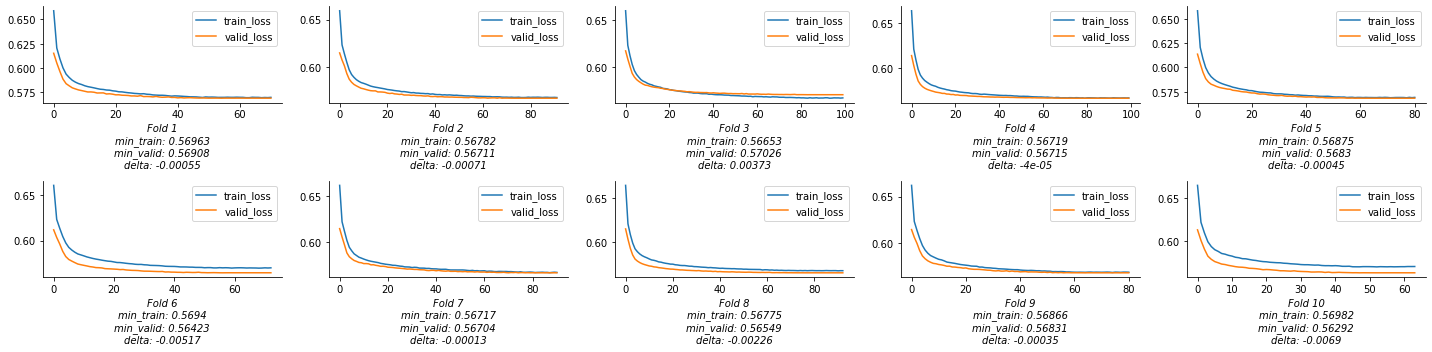

In [22]:
### plot train and valid loss over number of epochs
fig, ax = plt.subplots(2, 5, tight_layout=True, figsize=(20,5))
ax = ax.flatten() # 다차원 배열을 평평하게 해줌.

for fold in range(cv.n_splits):
    df_eval = pd.DataFrame({'train_loss': scores[fold]['loss'], 'valid_loss': scores[fold]['val_loss']})

    min_train = np.round(np.min(df_eval['train_loss']),5)
    min_valid = np.round(np.min(df_eval['valid_loss']),5)
    delta = np.round(min_valid - min_train,5)
    
    sns.lineplot(
        x=df_eval.index,
        y=df_eval['train_loss'],
        label='train_loss',
        ax = ax[fold]
    )

    sns.lineplot(
        x=df_eval.index,
        y=df_eval['valid_loss'],
        label='valid_loss',
        ax = ax[fold]
    )
    
    ax[fold].set_ylabel('')
    ax[fold].set_xlabel(f"Fold {fold+1}\nmin_train: {min_train}\nmin_valid: {min_valid}\ndelta: {delta}", fontstyle='italic')

sns.despine() # 테두리 제거

In [26]:
def postprocess_separate(submission_df, test_df=None, pure_df=None):
    """Update submission_df so that the predictions for the two sides of the hyperplane don't overlap.
    
    Parameters
    ----------
    submission_df : pandas DataFrame with columns 'id' and 'target'
    test_df : the competition's test data
    pure_df : the competition's original training data
    
    From https://www.kaggle.com/ambrosm/tpsnov21-007-postprocessing
    """
    
    sub = submission_df
    
    if pure_df is None: pure_df = pd.read_csv('./drive/MyDrive/tabular-playground-series-nov-2021/train.csv')
    if pure_df.shape != (600000, 102): raise ValueError("pure_df has the wrong shape")
    if test_df is None: test_df = pd.read_csv('./drive/MyDrive/tabular-playground-series-nov-2021/test.csv')
    if test_df.shape[0] != submission_df.shape[0] or test_df.shape[1] != 101: raise ValueError("test_df has the wrong shape")

    # Find the separating hyperplane for pure_df, step 1
    # Use an SVM with almost no regularization
    model1 = make_pipeline(StandardScaler(), LinearSVC(C=1e5, tol=1e-7, penalty='l2', dual=False, max_iter=2000, random_state=1))
    model1.fit(pure_df.drop(columns=['id', 'target']), pure_df.target)
    pure_pred = model1.predict(pure_df.drop(columns=['id', 'target']))
    print((pure_pred != pure_df.target).sum(), (pure_pred == pure_df.target).sum()) # 1 599999
    # model1 is not perfect: it predicts the wrong class for 1 of 600000 samples

    # Find the separating hyperplane for pure_df, step 2
    # Fit a second SVM to a subset of the points which contains the support vectors
    pure_pred = model1.decision_function(pure_df.drop(columns=['id', 'target']))
    subset_df = pure_df[(pure_pred > -5) & (pure_pred < 0.9)]
    model2 = make_pipeline(StandardScaler(), LinearSVC(C=1e5, tol=1e-7, penalty='l2', dual=False, max_iter=2000, random_state=1))
    model2.fit(subset_df.drop(columns=['id', 'target']), subset_df.target)
    pure_pred = model2.predict(pure_df.drop(columns=['id', 'target']))
    print((pure_pred != pure_df.target).sum(), (pure_pred == pure_df.target).sum()) # 0 600000
    # model2 is perfect: it predicts the correct class for all 600000 training samples
    
    pure_test_pred = model2.predict(test_df.drop(columns=['id', 'target'], errors='ignore'))
    lmax, rmin = sub[pure_test_pred == 0].target.max(), sub[pure_test_pred == 1].target.min()
    if lmax < rmin:
        print("There is no overlap. No postprocessing needed.")
        return
    # There is overlap. Remove this overlap
    sub.loc[pure_test_pred == 0, 'target'] -= lmax + 1
    sub.loc[pure_test_pred == 1, 'target'] -= rmin - 1
    print(sub[pure_test_pred == 0].target.min(), sub[pure_test_pred == 0].target.max(),
          sub[pure_test_pred == 1].target.min(), sub[pure_test_pred == 1].target.max())

In [34]:
### average predictions over each fold and create submission file
sample_submission['target'] = np.mean(np.column_stack(predictions), axis=1)
sample_submission.to_csv('./nn_baseline.csv', index=False)

postprocess_separate(sample_submission)
sample_submission.to_csv('./nn_baseline-with-post-processing.csv', index=False)

157559 442441
157657 442343
-1.630986213684082 -1.0 1.0 1.674155831336975
